# Import data from webhose.io

In [16]:
import os
import json
import webhoseio

data_path = './data'
model_path = './model'

### Useful function to write and read json files

In [17]:
def store_data(filename, data): 
    data_file = os.path.join(data_path, filename)
    with open(data_file, 'w') as outfile:
        json.dump(data, outfile)

def load_data(filename): 
    data_file = os.path.join(data_path, filename)
    with open(data_file) as json_data:
        data = json.load(json_data)
        return data

### Query to webhose.io

In [3]:
webhoseio.config(token="1a815770-8785-4596-a11c-09bdae034336")
query_params = {
    "q": "language:english site_type:news site_category:media organization:Microsoft", 
    "ts": "1555697996143",
    "sort": "crawled"
}

In [4]:
output = webhoseio.query("filterWebContent", query_params)
feeds = [ item for item in output['posts']]
while output['moreResultsAvailable'] > 0:
    output = webhoseio.get_next()
    feeds += [ item for item in output['posts']]

In [8]:
store_data('microsoft_0504_0604.json', feeds)

In [4]:
news_list = load_data('microsoft_0504_0604.json')
print('* Total number of news articles: {}'.format(len(news_list)))
print('* Date range: from {} to {}'.format(
    min([news_list[x]['published'] for x in range(len(news_list))]), 
    max([news_list[x]['published'] for x in range(len(news_list))])))

* Total number of news articles: 7948
* Date range: from 2019-05-04T03:00:00.000+03:00 to 2019-06-04T08:41:00.000+03:00



# Deduplicate titles 

In [5]:
import re
import time
import warnings
import numpy as np
import pandas as pd 

warnings.filterwarnings("ignore")

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
stopwords = set(nltk.corpus.stopwords.words('english'))

from gensim.models import KeyedVectors
from simhash import Simhash, SimhashIndex

### Useful function to cleanup text and load word2vec 

In [83]:
def cleanup_text(text):
    text = re.sub(r'http\S+', '', text)
    text = text.replace("'s", " ")
    text = text.replace("n't", " not ")
    text = text.replace("'ve", " have ")
    text = text.replace("'re", " are ")
    text = text.replace("I'm"," I am ")
    text = text.replace("you're"," you are ")
    text = text.replace("You're"," You are ")
    text = text.replace("-"," ")
    text = text.replace("/"," ")
    text = text.replace("("," ")
    text = text.replace(")"," ")
    text = text.replace("%"," percent ")
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    text = " ".join([i for i in text.lower().split() if i not in stopwords])
    token = [WordNetLemmatizer().lemmatize(i) for i in text.split()]
    return token

def load_wordvec_model(modelName, modelFile, flagBin):
    model = KeyedVectors.load_word2vec_format(os.path.join(model_path, modelFile), binary=flagBin)
    return model

### Load word2vec and webhose data

In [17]:
model_w2v_AP = load_wordvec_model('Word2Vec Google News', 'GoogleNews-vectors-negative300.bin.gz', True)
data = load_data('microsoft_0504_0604.json')

### Get titles, cleanup text, and apply Simhash

In [20]:
tot_title = len(data)
title_list = [' '.join(cleanup_text(str(data[i]['title']))) for i in range(tot_title)]
objs = [(i, Simhash(title_list[i])) for i in range(tot_title)]

#### Function checks whether the input words are present in the vocabulary for the model

In [21]:
def vocab_check(vectors, words):
    output = list()
    for word in words:
        if word in vectors.vocab:
            output.append(word.strip())
    return output

#### Function calculates similarity between two strings using a particular word vector model

In [22]:
def calc_similarity(input1, input2, vectors):
    s1words = set(vocab_check(vectors, input1.split()))
    s2words = set(vocab_check(vectors, input2.split()))
    
    output = vectors.n_similarity(s1words, s2words)
    return output

### Remove duplicate titles

In [23]:
def remove_duplicate(index, title_list, index_simahs, model_w2v_AP):
    duplicates = set()
    title = title_list[index]
    
    # calculate  hash value
    title_hash = Simhash(title)
    
    # find all duplicate indices
    dup_indices = index_simahs.get_near_dups(title_hash)

    # apply word2vec 
    for dupi in dup_indices:
        if int(dupi) == index: 
            continue
        try:
            score = calc_similarity(title, title_list[int(dupi)], model_w2v_AP)
        except:
            score = 0
        if score > 0.55:
            duplicates.add(int(dupi))
    return duplicates 

distance = 15
index_simahs = SimhashIndex(objs, k=distance)

index = 6241
print('Title: \n' + data[index]['title'] + '\n\nDuplicates:')
for i in remove_duplicate(index, title_list, index_simahs, model_w2v_AP): 
    print(data[i]['title'])

Title: 
Chinese Military Ditching Microsoft Windows To Avoid CIA's 'Hefty Arsenal Of Hacking Tools'

Duplicates:
Chinese Military Ditching Microsoft Windows To Avoid CIA’s ‘Hefty Arsenal Of Hacking Tools’
Chinese Military Ditching Microsoft Windows to Avoid CIA's Arsenal of Hacking Tools


In [24]:
start = time.clock()
duplicates = set()
for index in range(tot_title): 
    if index in duplicates: 
        continue 
    new_duplicates = remove_duplicate(index, title_list, index_simahs, model_w2v_AP);
    duplicates = duplicates.union(new_duplicates)
    if index % 2000 == 0 and index != 0: 
        print(str(index) + '/' + str(tot_title), len(duplicates), time.clock() - start)
    
new_feeds = data.copy()
for dup in sorted([int(dup) for dup in duplicates], reverse=True):
    del new_feeds[dup]

2000/7948 1036 141.879877
4000/7948 1819 251.23051999999998
6000/7948 2471 364.603786


In [ ]:
store_data('microsoft_0504_0604_clean.json', new_feeds)

In [9]:
news_cleaned_list = load_data('microsoft_0504_0604_clean.json')
print('* Total number of news articles once removed duplicates: {}'.format(len(news_cleaned_list)))
print('* Date range: from {} to {}'.format(
    min([news_list[x]['published'] for x in range(len(news_cleaned_list))]), 
    max([news_list[x]['published'] for x in range(len(news_cleaned_list))])))

* Total number of news articles once removed duplicates: 5021
* Date range: from 2019-05-04T03:00:00.000+03:00 to 2019-05-23T18:57:00.000+03:00


# Name Entity Recognition using IBM Watson

In [10]:
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions

In [11]:
data = load_data('microsoft_0504_0604_clean.json') 

### Query to IBM Watson

In [12]:
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2018-11-16',
    iam_apikey='N9R1KBh-8CJVJWSMGHB_lLG-Sq03-BurNjDc_dh5l9Id',
    url='https://gateway.watsonplatform.net/natural-language-understanding/api/v1/analyze?version=2018-11-16'
)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: NaturalLanguageUnderstandingV1 is a deprecated function. watson-developer-cloud moved to ibm-watson
  after removing the cwd from sys.path.


In [17]:
def get_title_WATSON_entities(text):
    entities_dict = dict()
    r = natural_language_understanding.analyze(
        text=text, features=Features(entities=EntitiesOptions(sentiment=True, limit=10))).get_result()
    for entity in r['entities']:
        entities_dict[entity['type']] = entity['text']
    return entities_dict

title = data[11]['title']
print(title)
get_title_WATSON_entities(title)

CBSE 10th Result 2019: Candidates can use alternative methods to provided by Google, Microsoft if official website is down


{'Company': 'Microsoft', 'JobTitle': 'official', 'Organization': 'CBSE'}

In [18]:
for i in range(len(data)): 
    title = data[i]['title']
    try:
        entities = get_title_WATSON_entities(title)
    except Exception:
        entities = dict()
    data[i]['title_entities'] = entities

In [18]:
store_data('microsoft_0504_0604_clean_with_entities.json', data)

NameError: name 'data' is not defined

In [19]:
news_cleaned_list = load_data('microsoft_0504_0604_clean_with_entities.json')
entity_title_list = [news['title_entities'] for news in news_cleaned_list if len(news['title_entities'].keys()) > 0]
tot_entities_dict = dict()
for entity_title in entity_title_list: 
    for entity in entity_title:
        if entity in tot_entities_dict.keys():
            tot_entities_dict[entity] += [entity_title[entity]]
        else:
            tot_entities_dict[entity] = [entity_title[entity]]
print('* Total number of news entities: {}'.format(len(tot_entities_dict)) + '\n')
print('* List of entities find in titles:\n -' + '\n -'.join(list(tot_entities_dict.keys())) + '\n')
print('* List of words associated with Broadcaster:\n -' + '\n -'.join(list(set(tot_entities_dict['Broadcaster']))))

* Total number of news entities: 27

* List of entities find in titles:
 -Person
 -Company
 -JobTitle
 -Location
 -GeographicFeature
 -Organization
 -Quantity
 -PrintMedia
 -Facility
 -Sport
 -Broadcaster
 -Number
 -Drug
 -Hashtag
 -HealthCondition
 -TwitterHandle
 -IPAddress
 -Movie
 -Date
 -Crime
 -Measure
 -MusicGroup
 -Money
 -TelevisionShow
 -Vehicle
 -Award
 -Percent

* List of words associated with Broadcaster:
 -FOX News
 -CNN
 -ABC
 -KTLA
 -HBO
 -BBC News
 -TMZ
 -CBS
 -NBC
 -Fox News


In [68]:
from collections import Counter
list_words = [text[1] for entity in entity_title_list for text in entity.items()]
counts = Counter(list_words)
print('word       |  count ')
for i in counts.most_common(25): 
    print('{:<10} | {}'.format(i[0], i[1]))

word       |  count 
Microsoft  | 915
Huawei     | 100
Google     | 92
Apple      | 60
US         | 47
Amazon     | 47
CNET       | 42
Sony       | 40
AI         | 36
Facebook   | 34
CEO        | 32
China      | 31
India      | 28
Chicago    | 22
UK         | 21
Bill Gates | 16
MSFT       | 16
Africa     | 16
partner    | 15
Samsung    | 15
Coast Live | 15
IBM        | 14
Twitter    | 14
U.S.       | 14
Intel      | 13


# Topic cluster using LDA

In [81]:
from gensim.models import ldamodel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim

In [84]:
titles = [[data[i]['title'], data[i]['published'][:10]]  for i in range(len(data))]
df_feeds = pd.DataFrame(titles,columns=['title', 'date'])
titles = df_feeds[['title']].applymap(cleanup_text)['title']

In [85]:
dictionary = Dictionary(titles)
dictionary.filter_extremes(no_below=20, no_above=0.8)
corpora = [dictionary.doc2bow(doc) for doc in titles]

# Running and Trainign LDA model on the document term matrix.
lda_model = ldamodel.LdaModel(corpora, num_topics=7, id2word = dictionary, passes=50)

In [86]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpora, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      16.495131        1       1  0.099937 -0.049649
3      16.368658        1       2  0.146633 -0.182974
5      14.697062        1       3 -0.018002  0.299570
6      14.435850        1       4  0.013077 -0.012772
2      14.120111        1       5  0.093023 -0.168273
1      12.869020        1       6  0.090381  0.196928
0      11.014168        1       7 -0.425049 -0.082829, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
28    Default   355.000000         2019   355.000000  30.0000  30.0000
19    Default   259.000000       window   259.000000  29.0000  29.0000
77    Default   264.000000       market   264.000000  28.0000  28.0000
16    Default   375.000000          new   375.000000  27.0000  27.0000
40    Default   197.000000        cloud   197.000000  26.0000  26.0000
8     Default   173.000000         tech   173.000000  25.0000  25.0000
22    Default   217.000000         game   217.000000  24.0000  24.0000
14    Default   172.000000           10   172.000000  23.0000  23.0000
102   Default   137.000000            u   137.000000  22.0000  22.0000
3     Default  1175.000000    microsoft  1175.000000  21.0000  21.0000
13    Default   139.000000      service   139.000000  20.0000  20.0000
193   Default   136.000000       huawei   136.000000  19.0000  19.0000
59    Default   189.000000         xbox   189.000000  18.0000  18.0000
170   Default   111.000000          day   111.000000  17.0000  17.0000
33    Default   117.000000         live   117.000000  16.0000  16.0000
90    Default   152.000000           ai   152.000000  15.0000  15.0000
27    Default   136.000000          may   136.000000  14.0000  14.0000
29    Default   236.000000       google   236.000000  13.0000  13.0000
129   Default   100.000000          say   100.000000  12.0000  12.0000
105   Default    99.000000          one    99.000000  11.0000  11.0000
17    Default   112.000000       update   112.000000  10.0000  10.0000
48    Default   101.000000         data   101.000000   9.0000   9.0000
222   Default    90.000000      company    90.000000   8.0000   8.0000
287   Default    91.000000        fox40    91.000000   7.0000   7.0000
177   Default    96.000000       global    96.000000   6.0000   6.0000
150   Default   159.000000        apple   159.000000   5.0000   5.0000
73    Default    90.000000     software    90.000000   4.0000   4.0000
186   Default    90.000000          ibm    90.000000   3.0000   3.0000
68    Default    75.000000        video    75.000000   2.0000   2.0000
213   Default    79.000000         sony    79.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
110    Topic7    55.204628            1    56.054951   2.1907  -3.5910
158    Topic7    49.755539         take    50.605911   2.1890  -3.6949
133    Topic7    49.673801         week    50.523643   2.1890  -3.6966
47     Topic7    47.253677   conference    48.104103   2.1882  -3.7465
34     Topic7    45.739567      student    46.589268   2.1876  -3.7791
35     Topic7    43.914196        today    44.764469   2.1868  -3.8198
175    Topic7    40.514904            3    41.364864   2.1852  -3.9004
328    Topic7    39.800541         city    40.650532   2.1849  -3.9182
294    Topic7    39.153820        storm    40.003239   2.1845  -3.9345
226    Topic7    37.720425     computer    38.570709   2.1837  -3.9718
5      Topic7    37.369598      weekend    38.219051   2.1835  -3.9812
7      Topic7    36.136639      startup    36.987019   2.1827  -4.0147
53     Topic7    33.601036        coast    34.450626   2.1810  -4.0875
230    Topic7    32.987038         work    33.837509   2.1805  -4.1059
290    Topic7    30.688618       school    31.538418   2.1787  -4.1781
97     Topic7    30.398878        still    31.249186   2.1784  

In [ ]:
# https://stackoverflow.com/questions/41819761/pyldavis-visualization-of-pyspark-generated-lda-model

# Topic cluster

# Microsoft stock prices

In [9]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from iexfinance.stocks import Stock
from iexfinance.stocks import get_historical_data

In [12]:
def get_prices(stock_name, t1, t2): 
    start = t1
    end = t2 
    stock = Stock(stock_name)
    return get_historical_data(stock_name, start=start, end=end, output_format='pandas')

def plot_candlestick(df):
    df["color"] = (df.close > df.open).map({True:"green",False:"red"})
    fig, ax = plt.subplots()
    for date in df.index:
        ax.plot([date]*2, df.loc[date, ["high","low"]].values, color = "black")
        ax.plot([date]*2, df.loc[date, ["open","close"]].values, color = df.loc[date, "color"], linewidth = 10)

    ax.set_ylabel("Price [$]")
    ax.set_xlabel("Day")
    ax.set_title("OHLC of Stock Value During Trading Day")
    plt.show()

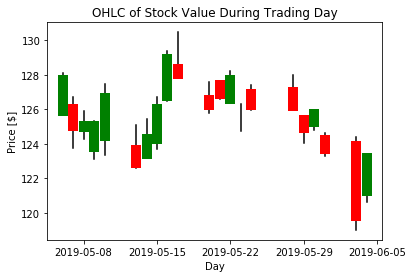

In [13]:
df = get_prices('MSFT', datetime.date(2019,5,4), datetime.date(2019,6,4))
plot_candlestick(df)